# Finding the Maximum Flux

In previous notebooks (N-MISC-17-003 pp 27-35) I have noted that the fluxes yielded by our K100 simulation at the two flux measurement points (called "low flux" and "high flux" locations) are discrepant.  The low flux point is typically lower in simulation by a factor of approximately 5 and the high flux point is higher in simulation by a factor of approximately 4.  This means that while [Matt and Nick's analysis][MandNflux] of the flux from Run 66 show about a factor of 100 between the low flux and high flux situations, the simulation shows a factor of nearly 1600.  

[MandNflux]: https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_66:pube_activation#more_thorough_estimate_of_pube_activation_rates "new analysis of flux measurements in Run 66"

Nevertheless, I have investigated the change of flux with small position variations in the source position.  The changes are displayed in the `R66_sim_position_shifting.ipynb` notebook in this directory and also referenced in N-MISC-17-003 pg 29.  Since those changes seem to vary sensibly we might hope that:

>_even though the simulation does not match the measurements, the positional scaling will be "somewhat indicative" of the true flux scaling_.

If that is the case then we can vary the position now and use the furthest position from the HV detector that keeps the flux reasonable to be a starting point for analyzing additional lead shielding to mitigate the gamma rate from having the source at that position.  

## Position Parameterization

The basic idea is to use a position close to the high flux point and the low flux point as endpoints of a line along which to do several simulations of the source to see if there's a place that has a flux in the 1$\,$n/cm$^2$s range according to the simulation.  At that point we can try to vary the shielding to include a reasonable amount of lead near the source so that the NaI detector rate is reasonable.  We can also use the variation along the source line to form an intuitive picture for how the flux behaves. 

In [1]:
import numpy as np

#first we need the endpoints -- label 'h' for high flux
xh = 0 #cm
yh = 33.02 #N-MISC-17-003 pg 29, #trelloP1
zh = 0 #should be near detector height
p_h = np.asarray([xh,yh,zh],dtype=np.float64)

#see the file templates/Run66Shield_stdLocation_inBarrel.mac.template for the standard position point--label
#'l' for low flux
xl = 0 #cm
yl = 119.731
zl = -64.679
p_l = np.asarray([xl,yl,zl],dtype=np.float64)

#get unit vector pointing from high flux to low flux
ltot = np.linalg.norm(p_l-p_h)
uvec = (p_l-p_h)/ltot

#chop up the region
N = 10
for i in np.arange(N+1):
    d = ltot/np.float(N)
    vec = p_h + i*d*uvec
    print(vec)


[  0.    33.02   0.  ]
[  0.      41.6911  -6.4679]
[  0.      50.3622 -12.9358]
[  0.      59.0333 -19.4037]
[  0.      67.7044 -25.8716]
[  0.      76.3755 -32.3395]
[  0.      85.0466 -38.8074]
[  0.      93.7177 -45.2753]
[   0.      102.3888  -51.7432]
[   0.      111.0599  -58.2111]
[   0.     119.731  -64.679]


## Scanning the Source Position and Measuring Flux



In [2]:
import dataPython as dp
import scipy as sp
from scipy.stats import poisson

#a function to get three rows of data x y z
data = dp.getXYZdata('data/Run66Sim_FluxScan0.txt')
dataF1 = dp.getXYZdata('data/Run66Sim_FluxScan1.txt')

#turn into np array
data['xx'] = np.array(data['xx'])
data['yy'] = np.array(data['yy'])
data['zz'] = np.array(data['zz'])

dataF1['xx'] = np.array(dataF1['xx'])
dataF1['yy'] = np.array(dataF1['yy'])
dataF1['zz'] = np.array(dataF1['zz'])

#include sqrt(N) error
data['ey'] = np.sqrt(data['yy'])
data['eyl'],data['eyu'] = sp.stats.poisson.interval(0.68, data['yy'])
data['eyl'] = np.abs(data['yy']-data['eyl'])
data['eyu'] = np.abs(data['yy']-data['eyu'])

dataF1['ey'] = np.sqrt(dataF1['yy'])
dataF1['eyl'],dataF1['eyu'] = sp.stats.poisson.interval(0.68, dataF1['yy'])
dataF1['eyl'] = np.abs(dataF1['yy']-dataF1['eyl'])
dataF1['eyu'] = np.abs(dataF1['yy']-dataF1['eyu'])

#add in the factors for neutron flux V=258.5 cm^3; Sig=0.0955 cm^-1; nPrim=1e6; Source R=1.96e6 neut/s
V=258.50
Sig=0.0955
nPrim=data['zz']*1e6
SrcR=1.96e6

data['yy'] = data['yy']*(SrcR/nPrim)*(1/(V*Sig))
data['ey'] = data['ey']*(SrcR/nPrim)*(1/(V*Sig))
data['eyl'] = data['eyl']*(SrcR/nPrim)*(1/(V*Sig))
data['eyu'] = data['eyu']*(SrcR/nPrim)*(1/(V*Sig))

dataF1['yy'] = dataF1['yy']*(SrcR/nPrim)*(1/(V*Sig))
dataF1['ey'] = dataF1['ey']*(SrcR/nPrim)*(1/(V*Sig))
dataF1['eyl'] = dataF1['eyl']*(SrcR/nPrim)*(1/(V*Sig))
dataF1['eyu'] = dataF1['eyu']*(SrcR/nPrim)*(1/(V*Sig))

print(data['ey'])
print(data['eyl'])
print(data['eyu'])

[ 0.62278574  0.26236353  0.1146814   0.08364763  0.07145534  0.04491249
  0.03074948  0.02381845  0.02100589  0.01247569]
[ 0.61751524  0.2620029   0.1146814   0.07939482  0.07145534  0.04763689
  0.03175793  0.02381845  0.02381845  0.00882165]
[ 0.61751524  0.2620029   0.1146814   0.07939482  0.07145534  0.04763689
  0.03175793  0.02381845  0.02381845  0.00882165]


In [3]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

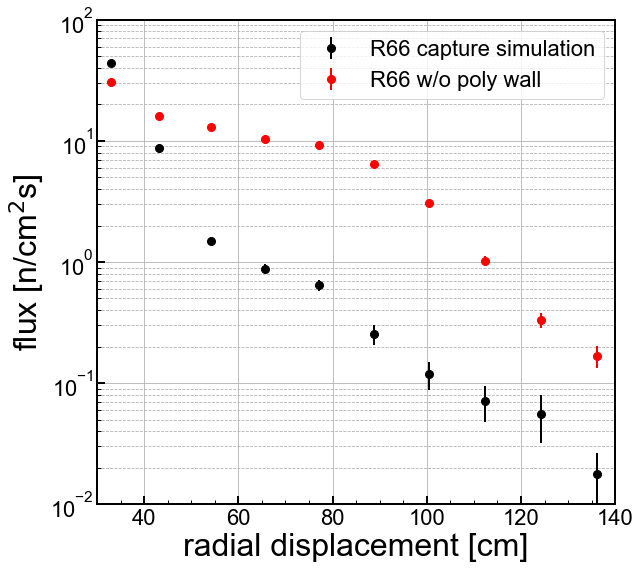

In [4]:
#set up a plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0))
ax1 = axes

#lay out the colors
rgb_r = (255/255.0,0/255.0,0/255.0)
rgb_b = (0/255.0,0/255.0,255/255.0)
rgb_o = (255/255.0,127/255.0,0/255.0)
rgb_b = (31/255.0,120/255.0,180/255.0)
rgb_lr = (251/255.0,154/255.0,153/255.0)
rgb_g = (203/255.0,195/255.0,195/255.0)

ax1.errorbar(data['xx'], data['yy'], yerr=[data['eyl'],data['eyu']],marker='o', markersize=8, \
             linestyle='none',color='k', label='R66 capture simulation')
ax1.errorbar(dataF1['xx'], dataF1['yy'], yerr=[dataF1['eyl'],dataF1['eyu']],marker='o', markersize=8, \
             linestyle='none',color='r', label='R66 w/o poly wall')
#ax1.errorbar(dataV0['xx'], dataV0['yy'], yerr=dataV0['ey'],marker='o', markersize=8, linestyle='none',color='r', label='standard position')
#xx = np.arange(0,13,dx)


ax1.set_yscale('log')
ax1.set_xlim(30, 140)
ax1.set_ylim(1e-2,100)
ax1.set_xlabel('radial displacement [cm]',**axis_font)
ax1.set_ylabel('flux [n/cm$^2$s]',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/thefigure.png')
plt.show()